In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import reverse_geocoder as rd
from scipy.interpolate import interp1d
import plotly.express as px
import pycountry
import folium

%matplotlib inline

In [2]:
covid_19 = pd.read_csv('/home/ec2-user/SageMaker/covid_19_clean_complete.csv', encoding = "ISO-8859-1", engine='python')

In [3]:
covid_19.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0,0


In [4]:
covid_19.shape

(24104, 8)

In [5]:
indexNames = covid_19[ covid_19['Date'] != '4/22/20' ].index #Keeping only recent date which is 4/22/20 and droping other rows
covid_19.drop(indexNames , inplace=True)

In [6]:
covid_19.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
23842,NaN,Afghanistan,33.0000,65.0000,4/22/20,1176,40,166
23843,NaN,Albania,41.1533,20.1683,4/22/20,634,27,356
23844,NaN,Algeria,28.0339,1.6596,4/22/20,2910,402,1204
23845,NaN,Andorra,42.5063,1.5218,4/22/20,723,37,309
23846,NaN,Angola,-11.2027,17.8739,4/22/20,25,2,6


In [7]:
covid_19.describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,262.000000,262.000000,262.000000,262.000000,262.000000
mean,21.433571,22.597991,10013.007634,698.568702,2635.038168
std,24.787770,70.704558,57336.338327,3956.967454,11746.201963
min,-51.796300,-135.000000,-1.000000,-1.000000,0.000000
25%,7.135000,-18.093125,66.250000,1.000000,7.000000
50%,23.659750,20.921188,384.500000,7.000000,106.000000
75%,41.191625,80.250000,1792.500000,45.500000,567.500000
max,71.706900,178.065000,839675.000000,46583.000000,99400.000000


In [8]:
covid_19.dtypes

Province/State     object
Country/Region     object
Lat               float64
Long              float64
Date               object
Confirmed           int64
Deaths              int64
Recovered           int64
dtype: object

In [9]:
covid_19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 23842 to 24103
Data columns (total 8 columns):
Province/State    80 non-null object
Country/Region    262 non-null object
Lat               262 non-null float64
Long              262 non-null float64
Date              262 non-null object
Confirmed         262 non-null int64
Deaths            262 non-null int64
Recovered         262 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 18.4+ KB


In [10]:
covid_19.isnull().sum()

Province/State    182
Country/Region      0
Lat                 0
Long                0
Date                0
Confirmed           0
Deaths              0
Recovered           0
dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


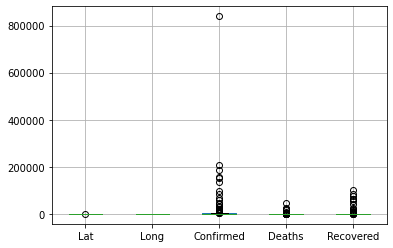

In [11]:
print(covid_19.boxplot())

In [12]:
covid_19[covid_19.Confirmed< 0] #checking how many Confirmed cases are less than 0 - Outliers

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
23879,Grand Princess,Canada,37.6489,-122.6655,4/22/20,-1,-1,0
24073,Diamond Princess,Canada,0.0000,0.0000,4/22/20,-1,-1,0


In [13]:
covid_19.drop([23879,24073], inplace = True)

In [14]:
covid_19.describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,260.000000,260.000000,260.000000,260.000000,260.000000
mean,21.453641,23.243613,10090.038462,703.950000,2655.307692
std,24.827180,70.383768,57550.509370,3971.736558,11789.175608
min,-51.796300,-135.000000,1.000000,0.000000,0.000000
25%,7.405000,-16.237775,70.000000,1.000000,7.750000
50%,23.659750,20.972650,413.000000,7.000000,107.500000
75%,41.227200,81.812500,1833.750000,46.500000,571.750000
max,71.706900,178.065000,839675.000000,46583.000000,99400.000000


# Data Imputation and Manipulation

In [15]:
pickup = list(zip(covid_19.Lat,covid_19.Long)) #Picking Latitude and Longitude from dataframe covid_19 and converting data into list
pickup

[(33.0, 65.0),
 (41.1533, 20.1683),
 (28.0339, 1.6596),
 (42.5063, 1.5218),
 (-11.2027, 17.8739),
 (17.0608, -61.7964),
 (-38.4161, -63.6167),
 (40.0691, 45.0382),
 (-35.4735, 149.0124),
 (-33.8688, 151.2093),
 (-12.4634, 130.8456),
 (-28.0167, 153.4),
 (-34.9285, 138.6007),
 (-41.4545, 145.9707),
 (-37.8136, 144.9631),
 (-31.9505, 115.8605),
 (47.5162, 14.5501),
 (40.1431, 47.5769),
 (25.0343, -77.3963),
 (26.0275, 50.55),
 (23.685, 90.3563),
 (13.1939, -59.5432),
 (53.7098, 27.9534),
 (50.8333, 4.0),
 (9.3077, 2.3158),
 (27.5142, 90.4336),
 (-16.2902, -63.5887),
 (43.9159, 17.6791),
 (-14.235, -51.9253),
 (4.5353, 114.7277),
 (42.7339, 25.4858),
 (12.2383, -1.5616),
 (16.5388, -23.0418),
 (11.55, 104.9167),
 (3.8480000000000003, 11.5021),
 (53.9333, -116.5765),
 (49.2827, -123.1207),
 (53.7609, -98.8139),
 (46.5653, -66.4619),
 (53.1355, -57.6604),
 (44.681999999999995, -63.7443),
 (51.2538, -85.3232),
 (46.5107, -63.4168),
 (52.9399, -73.5491),
 (52.9399, -106.4509),
 (6.6111, 20.93

In [16]:
get = rd.search(pickup) #Using reverse geo code to get the city/province/state name from latitude and longitude
get

Loading formatted geocoded file...


[OrderedDict([('lat', '33.20357'),
              ('lon', '65.47311'),
              ('name', 'Kajran'),
              ('admin1', 'Daykundi'),
              ('admin2', ''),
              ('cc', 'AF')]),
 OrderedDict([('lat', '41.14056'),
              ('lon', '20.14611'),
              ('name', 'Labinot-Fushe'),
              ('admin1', 'Elbasan'),
              ('admin2', 'Rrethi i Elbasanit'),
              ('cc', 'AL')]),
 OrderedDict([('lat', '27.19351'),
              ('lon', '2.46069'),
              ('name', 'I-n-Salah'),
              ('admin1', 'Tamanghasset'),
              ('admin2', ''),
              ('cc', 'DZ')]),
 OrderedDict([('lat', '42.50779'),
              ('lon', '1.52109'),
              ('name', 'Andorra la Vella'),
              ('admin1', 'Andorra la Vella'),
              ('admin2', ''),
              ('cc', 'AD')]),
 OrderedDict([('lat', '-12.01667'),
              ('lon', '17.48333'),
              ('name', 'Camacupa'),
              ('admin1', 'Bie'),
     

In [17]:
city = [d['name'] for d in get] #Fetching names of city from the dictionary
list(city)

['Kajran',
 'Labinot-Fushe',
 'I-n-Salah',
 'Andorra la Vella',
 'Camacupa',
 'All Saints',
 'Jacinto Arauz',
 "T'azagyugh",
 'Macarthur',
 'Sydney',
 'Darwin',
 'Surfers Paradise',
 'Adelaide',
 'Penguin',
 'Melbourne',
 'Perth',
 'Johnsbach',
 'Agdzhabedy',
 'Nassau',
 'Dar Kulayb',
 'Azimpur',
 'Welchman Hall',
 'Dukora',
 'Ninove',
 'Beterou',
 'Trongsa',
 'Ascension',
 'Voljevac',
 'Mozarlandia',
 'Tutong',
 'Tryavna',
 'Ouagadougou',
 'Santa Maria',
 'Phnom Penh',
 'Yaounde',
 'Edson',
 'West End',
 'Thompson',
 'Fredericton',
 'Saint-Augustin',
 'Dartmouth',
 'Hornepayne',
 'Kensington',
 'Chibougamau',
 'Shellbrook',
 'Ippy',
 'Ati',
 'Colbun',
 'Hefei',
 'Xiaotangshan',
 'Gaojia',
 'Xinyang',
 'Obo',
 'Zhongluotan',
 'Xincheng Chengguanzhen',
 'Guiyang',
 'Limushan',
 'Liulihe',
 'Sihaidian',
 'Shuangmiao',
 'Kowloon',
 'Macheng',
 'Lianyuan',
 'Mandalt',
 'Zhoushan',
 'Gongfang',
 'Kouqian',
 'Gaotuo',
 'Macau',
 'Hongsipu',
 'Dagur',
 'Guanzhuang',
 'Nanma',
 'Xuhui',
 'Qing

In [18]:
covid_19['City'] = city

In [19]:
covid_19.loc[covid_19['Province/State'].isnull(),'Province/State'] = covid_19.City

In [20]:
covid_19.tail(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,City
24099,Saint Pierre and Miquelon,France,46.885200,-56.315900,4/22/20,1,0,0,Saint-Pierre
24100,Bor,South Sudan,6.877000,31.307000,4/22/20,4,0,0,Bor
24101,Gueltat Zemmour,Western Sahara,24.215500,-12.885800,4/22/20,6,0,0,Gueltat Zemmour
24102,Sao Tome,Sao Tome and Principe,0.186360,6.613081,4/22/20,4,0,0,Sao Tome
24103,Al Batinah,Yemen,15.552727,48.516388,4/22/20,1,0,0,Al Batinah


In [21]:
covid_19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 23842 to 24103
Data columns (total 9 columns):
Province/State    260 non-null object
Country/Region    260 non-null object
Lat               260 non-null float64
Long              260 non-null float64
Date              260 non-null object
Confirmed         260 non-null int64
Deaths            260 non-null int64
Recovered         260 non-null int64
City              260 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 30.3+ KB


In [22]:
#Grouping data by country name and summing u no. of confirmed, deaths and recovered cases

grp = covid_19.groupby(('Country/Region'),sort = False, as_index=False)
 
x = grp['Confirmed'].agg(np.sum)
y = grp['Deaths'].agg(np.sum)
z = grp['Recovered'].agg(np.sum)

In [23]:
covid_19_copy = covid_19.copy() #Creating a copy of dataframe
covid_19_copy = covid_19_copy.apply(lambda col: col.drop_duplicates().reset_index(drop=True)) #Dropping all the duplicate countries name
covid_19_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 9 columns):
Province/State    257 non-null object
Country/Region    185 non-null object
Lat               252 non-null float64
Long              255 non-null float64
Date              1 non-null object
Confirmed         229 non-null float64
Deaths            95 non-null float64
Recovered         179 non-null float64
City              257 non-null object
dtypes: float64(5), object(4)
memory usage: 18.1+ KB


In [24]:
covid_19_copy = covid_19_copy.drop(['Confirmed', 'Deaths','Recovered','Date','Province/State','City'], axis=1) 

In [25]:
covid_19_copy.head(5)

,Country/Region,Lat,Long
0,Afghanistan,33.0000,65.0000
1,Albania,41.1533,20.1683
2,Algeria,28.0339,1.6596
3,Andorra,42.5063,1.5218
4,Angola,-11.2027,17.8739


In [26]:
covid_19_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 3 columns):
Country/Region    185 non-null object
Lat               252 non-null float64
Long              255 non-null float64
dtypes: float64(2), object(1)
memory usage: 6.1+ KB


In [27]:
covid_19_copy = covid_19_copy.drop(covid_19_copy.index[185:256]) #Cleaning the new dataframe by dropping extra rows in Latitude and Longitude

In [28]:
covid_19_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 0 to 256
Data columns (total 3 columns):
Country/Region    185 non-null object
Lat               185 non-null float64
Long              185 non-null float64
dtypes: float64(2), object(1)
memory usage: 5.8+ KB


In [29]:
#concatenating Confirmed, deaths and recovered data to dataframe covid_19_copy

covid_19_copy = pd.concat([covid_19_copy, x[['Confirmed']]], axis=1,join='inner')
covid_19_copy = pd.concat([covid_19_copy, y[['Deaths']]], axis=1,join='inner')
covid_19_copy = pd.concat([covid_19_copy, z[['Recovered']]], axis=1,join='inner')

In [30]:
covid_19_copy.head(5)

,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
0,Afghanistan,33.0000,65.0000,1176,40,166
1,Albania,41.1533,20.1683,634,27,356
2,Algeria,28.0339,1.6596,2910,402,1204
3,Andorra,42.5063,1.5218,723,37,309
4,Angola,-11.2027,17.8739,25,2,6


# Data Visulization (Map Creation)

In [43]:
m = interp1d([1,max(x)],[5,16])
fig = px.density_mapbox(covid_19, lat='Lat', lon='Long', z = 'Confirmed', radius=10, zoom=0,
                        mapbox_style='carto-positron')
fig.show()

In [44]:
m = interp1d([1,max(x)],[5,16])
fig = px.density_mapbox(covid_19, lat='Lat', lon='Long', z = 'Deaths', radius=10, zoom=0,
                        mapbox_style='carto-positron')
fig.show()

In [45]:
m = interp1d([1,max(x)],[5,16])
fig = px.density_mapbox(covid_19, lat='Lat', lon='Long', z = 'Recovered', radius=10, zoom=0,
                        mapbox_style='carto-positron')
fig.show()

In [34]:
fig = px.scatter_geo(covid_19_copy, lat='Lat', lon='Long',color="Country/Region",
                     hover_name="Country/Region", size="Confirmed",
                     projection="natural earth")

fig.show()

In [35]:
fig = px.scatter_geo(covid_19_copy, lat='Lat', lon='Long',color="Country/Region",
                     hover_name="Country/Region", size="Deaths",
                     projection="natural earth")

fig.show()

In [36]:
fig = px.scatter_geo(covid_19_copy, lat='Lat', lon='Long',color="Country/Region",
                     hover_name="Country/Region", size="Recovered",
                     projection="natural earth")

fig.show()